## Assignment 2: System Dynamics.
**Course:** Simulation Modeling of Financial and Economic Systems <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 <br>

### 0. Prerequisites

In [1]:
# %pip install pysd

In [1]:
import os
import pysd
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
from datetime import datetime
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor

### 1. Importing model

In [3]:
model = pysd.load('./bass.py')

In [4]:
model.doc().head()

,Real Name,Py Name,Unit,Lims,Type,Subs,Eqn,Comment
0,Competitor Customers,competitor_customers,person,"(None, None)",component,None,"INTEG(-competitor gain, 0)",
1,Competitor Customers -> Our Customers,competitor2our,person,"(None, None)",component,None,luring_threshold * efficiency_word_of_mouth * ...,
2,Competitor Customers -> Potential Customers,competitor2potential,person,"(None, None)",component,None,competitor_customers * p23 * share_dissatisfied,
3,Concentration of Potential Customers,potential_customers_concentration,float,"(None, None)",component,None,Potential Customers / Total Market,
4,Demand from Marketing,marketing_demand,person,"(None, None)",component,None,Efficiency Marketing / Potential Customers,


In [5]:
def run_model(model, params=None, return_columns=None):
    """
    Method that simulates the system dynamics using Bass model.
    The model is flexible, so that you can configure (a) the time
    simulation will be running, (b) probabilities P11 P13 P21 P23, 
    (c) Efficiency of marketing and word of mouth (WoM), and (d) so-
    ciability. 
    User can restrict the columns to be returned.

    :param model: Bass model loaded from ./bass.py
    :param params: dict with configurations (a-d)
    :return_columns: columns of interest
    :return: values of intersted attributes at each point in time    
    """
    model.reload()
    kwargs = {}
    if params is not None:
        kwargs['params'] = params
    values = model.run(**kwargs)
    return values

In [6]:
def plot_chart(values):
    """
    The method that plots chart for a given values.
    The input should produced by run_model function, and
    contain columns 'Potential Customers', 'Our 
    Customers', 'Competitor Customers'.

    :param values: values to be plotted
    """
    labels = ['Potential Customers', 'Our Customers', 'Competitor Customers']
    values = values[labels]
    values_len = len(values)
    colors = ['g', 'b', 'r']

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 12)
    ax1.set_title(f"Market Segmentation")
    ax1.grid(linestyle="--")
    ax1.set_xlabel("Month")
    ax1.set_ylabel("Data")
    for label, color in zip(labels, colors):
        ax1.plot(np.arange(values_len), values[label], '-', label=label, c=color)
    ax1.legend()
    plt.show() 

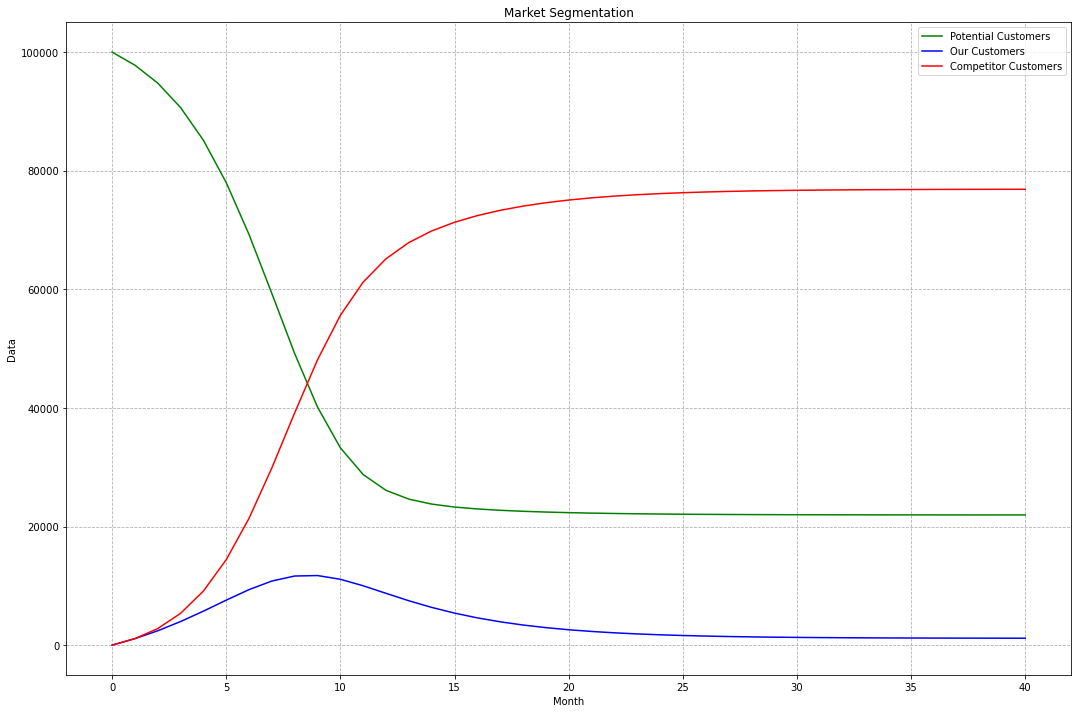

In [7]:
config = {
    "final_time": 40,
    "p11": 0.3,
    "p13": 0.5,
    "p21": 0.5,
    "p23": 0.4,
    "efficiency_word_of_mouth": 0.015,
    "efficiency_marketing": 0.011,
    "sociability": 100
}


values = run_model(model, params=config)
plot_chart(values)

### 2. Convergence Estimation

In [8]:
def get_equilibrium(values, eps=5e-1):
    """
    Method that computes market segmentation for a given model run.
    The observations are said to converge at time T iff |x_T - x_i| < eps
    for i ∈ [1..5]. Resultant values M1, M2 are values of columns 'Our Customers'
    and 'Competitor Customers' at time moment T. If the convergence test failed, 
    then it returns (None, None).

    :param values: dataframe (output of run)
    :param eps: epsilon value
    :return: M1, M2
    """
    labels = ['Potential Customers', 'Our Customers', 'Competitor Customers']
    new_labels = []
    new_values = values.copy()
    for label in labels:
        for offset in range(1, 6):
            new_label = f"{label} - {offset}"
            new_labels.append(new_label)
            new_values[new_label] = values[label].diff(periods=offset).abs()
    diffs = new_values[new_labels]
    converged = values[(diffs < eps).all(axis='columns')]
    if converged.empty:
        return None, None
    M1, M2 = converged[labels[1:]].iloc[0]
    return M1, M2


In [9]:
def simulate(p11, p13, p21, p23, final_time=1000):
    """
    Method that runs simulation with given values 
    of P11, P13, P21, and P23. 

    :param p11: P11
    :param p13: P13
    :param p21: P21
    :param p23: P23
    :param final_time: simulation time
    :return: M1, M2
    """
    config = {
        "final_time": final_time,
        "p11": p11,
        "p13": p13,
        "p21": p21,
        "p23": p23,
        "efficiency_word_of_mouth": 0.015,
        "efficiency_marketing": 0.011,
        "sociability": 100
    }
    values = run_model(model, params=config)
    equilibrium = get_equilibrium(values)
    return np.array(equilibrium)

In [10]:
simulate(p11=0.3, p13=0.5, p21=0.5, p23=0.4)

array([ 1154.22876465, 76893.42423312])

### 3. Data Preparation

In [11]:
def simulate_wrapper(args):
    """
    Wrapper for simulate method. Used to run simulations
    in parallel.

    :return: M1, M2
    """
    return simulate(*args)

In [12]:
def generate_grid(step=0.1, preferences=None):
    """
    Method that generates a grid of P11, P13, P21, P23. Can forced to compute
    the grid within a certain interval for each P.

    :param step: grid size
    :param preferences: list of lists of elements with two items: lower and upper bound for P
    :return: dataframe 
    """
    if preferences is None:
        preferences = [[0, 1]] * 4
    preferences = np.array(preferences)
    assert preferences.shape == (4, 2), "Preferences is list of list of elements with two items: lower and upper bound for P"
    space = [np.arange(pref[0], pref[1] + step, step) for pref in preferences]
    grid = np.array(np.meshgrid(*space, indexing='ij')).T.reshape(-1, 4)
    labels =  ["P11", "P13", "P21", "P23", "S1", "S2"]
    df = pd.DataFrame(data=grid, columns=labels[:4])
    temp = pd.DataFrame(data=np.zeros((len(df), 2)), columns=labels[4:])
    for idx, label in enumerate(labels[4:]):
        temp[label] = df[labels[idx * 2]] + df[labels[idx * 2 + 1]]
    df = df[(temp <= 1.).all(axis='columns')].reset_index(drop=True)
    return df

In [13]:
def get_mapping(df):
    """
    Method that computes equilibrium of a system with a given
    set of P11, P13, P21, P23. Uses multiple processes to increase
    the speed.

    :param df: dataframe with predictors
    :return: ground truth
    """
    work = [[r["P11"], r["P13"], r["P21"], r["P23"]] for _, r in df.iterrows()]
    with Pool(max(os.cpu_count() - 1, 1)) as p:
        ground_truth = list(tqdm(p.imap(simulate_wrapper, work), total=len(work)))
    targets = pd.DataFrame(data=ground_truth, columns=["M1", "M2"])
    return targets

In [14]:
def export(df, flag):
    """
    Method that saves dataframe as a csv file.

    :param df: dataframe to be saved
    :param flag: flag whether it should be saved
    :return: True if save successfully
    """
    if not flag:
        return
    if not os.path.exists('./data'):
        os.makedirs('./data')
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    filepath = os.path.join('./data', f'train | {timestamp}.csv')
    df.to_csv(filepath)
    return True

In [15]:
def compose_dataset(step=0.1, preferences=None, save=True):
    """
    Method that assembles dataset.

    :param step: grid size
    :param preferences: list of lists of elements with two items: lower and upper bound for P
    :param save: flag whether the result should be saved
    :return: dataframe 
    """
    df = generate_grid(step=step, preferences=preferences)
    targets = get_mapping(df)
    dataset = pd.concat([df, targets], axis=1).fillna(value=np.nan)
    export(dataset, save)        
    return dataset


In [16]:
preferences = [[0.1, 0.9]] * 4
df = compose_dataset(step=0.05, preferences=preferences)

100%|██████████| 18496/18496 [57:38<00:00,  5.35it/s] 


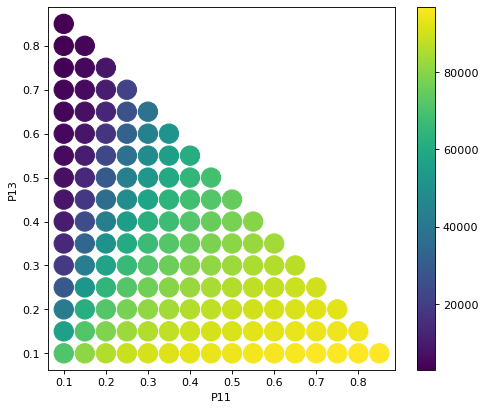

In [20]:
from matplotlib.pyplot import figure

def visualize(dataset, competitor_strategy, tol=1e-5):
    """
    Method that generates colored map of market segmentation
    for each pair P11 and P13.

    :param dataset: dataframe with values of P and M
    :param competitor_strategy: P21 and P23
    :param tol: tolerance in float poat computing
    """
    p21, p23 = competitor_strategy
    data = dataset[(abs(dataset["P21"] - p21) < tol) & (abs(dataset["P23"] - p23) < tol)]
    figure(figsize=(7, 6), dpi=80)
    plt.scatter(data["P11"], data["P13"], c=data["M1"], s=300)
    plt.xlabel("P11")
    plt.ylabel("P13")
    plt.colorbar()
    
visualize(df, [0.1, 0.3])

### 4. Machine Learning Model

In [2]:
df = pd.read_csv("./data/train.csv", index_col=[0])

In [3]:
df.dropna(inplace=True)

In [4]:
config = {
    "Epochs": 100,
    "Layers": [4, 256, 256, 256, 256, 2],
    "Learning rate": 1e-1,
    "Weight decay": 5e-4,
    "Batch size": 100,
    "Num workers": 4,
    "Device": "cuda"  
}

In [5]:
class BassDataset(Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        X = item[["P11", "P13", "P21", "P23"]].to_numpy()
        y = item[["M1", "M2"]].to_numpy()
        
        X = torch.tensor(X)
        y = torch.tensor(y)
        return X, y

In [6]:
trainset = BassDataset(df)
trainloader = DataLoader(trainset, batch_size=config["Batch size"], shuffle=False, num_workers=config["Num workers"])

In [7]:
class BlockAE(nn.Module):
    def __init__(self, input_dim, output_dim, activation):
        super(BlockAE, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            activation()
        )
        
    def forward(self, x):
        out = self.main(x)
        return out


class MLP(nn.Module):

    def __init__(self, layers, activation=nn.ReLU):
        super(MLP, self).__init__()
        self.layers = layers
        self.activation = activation
        self.main = self.__init_model(layers)
    
    def __init_model(self, layers):
        sequence = []
        for idx in range(len(layers) - 2):
            layer = BlockAE(layers[idx], layers[idx + 1], self.activation)
            sequence.append(layer)
        sequence.append(nn.Linear(layers[-2], layers[-1], self.activation))
        return torch.nn.Sequential(*sequence)
    
    def forward(self, x):
        out = self.main(x)
        return out

In [8]:
def make():
    model = MLP(config["Layers"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["Learning rate"], weight_decay=config["Weight decay"])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, config["Learning rate"], config['Epochs'], steps_per_epoch=len(trainloader))
    criterion = nn.MSELoss()
    return model, optimizer, scheduler, criterion

In [9]:
def train(model, criterion, loader, optimizer):
    """
    Training routine for the model. Iterates over the elements in the loader.
    Uses criterion to calculate the loss. Applies optimizer to update weights.
    :param model: PyTorch model
    :param criterion: method computing the loss 
    :param loader: dataloader
    :param optimizer: optimization algorithm
    :return: per batch loss, average balanced accuracy
    """
    model.to(config['Device'])
    model.train()
    
    train_loss = 0.0
    for _, (X, y) in enumerate(loader):
        X, y = X.to(config['Device']).float(), y.to(config['Device']).float()
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    return train_loss / len(loader)

In [10]:
def pipeline():
    model, optimizer, scheduler, criterion = make()
    losses = {'train': []}

    for epoch in range(config['Epochs']):  
        train_loss = train(model, criterion, trainloader, optimizer)
        scheduler.step()
        
        losses['train'].append(train_loss)
        print(f"Epoch: {epoch+1:02d} | Train loss: {train_loss:.5f}")

        if train_loss <= min(losses['train']):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss, 
            }, os.path.join("weights", f"{epoch}.pt"))
    return losses

In [11]:
losses = pipeline()

Epoch: 01 | Train loss: 1804784527.74054
Epoch: 02 | Train loss: 1790674843.50270
Epoch: 03 | Train loss: 1776234376.99459
Epoch: 04 | Train loss: 1699201707.50270
Epoch: 05 | Train loss: 1750997348.47568
Epoch: 06 | Train loss: 1516506100.10811
Epoch: 07 | Train loss: 339834397.79459
Epoch: 08 | Train loss: 243011709.48108
Epoch: 09 | Train loss: 181580396.83243
Epoch: 10 | Train loss: 126689159.04324
Epoch: 11 | Train loss: 103232104.26757
Epoch: 12 | Train loss: 80827229.17027
Epoch: 13 | Train loss: 83700052.18581
Epoch: 14 | Train loss: 101095604.06216
Epoch: 15 | Train loss: 87099425.11892
Epoch: 16 | Train loss: 56660871.23378
Epoch: 17 | Train loss: 119934917.63851
Epoch: 18 | Train loss: 71387258.54865
Epoch: 19 | Train loss: 64602605.35946
Epoch: 20 | Train loss: 54944313.43108
Epoch: 21 | Train loss: 43785192.70608
Epoch: 22 | Train loss: 52449730.06081
Epoch: 23 | Train loss: 47597270.54324
Epoch: 24 | Train loss: 41069790.53919
Epoch: 25 | Train loss: 48803959.34054
Epoch:

In [12]:
def visualize(losses):
    """
    Method used to visualize the behaviour of losses over the time.
    :param losses: dict with keys 'train', 'test' and values - losses.
    :param accuracies: dict with keys 'train', 'test' and values - balanced accuracies.
    """
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    ax1.set_title(f"Comparison of losses")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(np.arange(len(losses['train'])), np.array(losses['train']), '-', label='Train', c='b')
    ax1.legend()

    plt.show() 

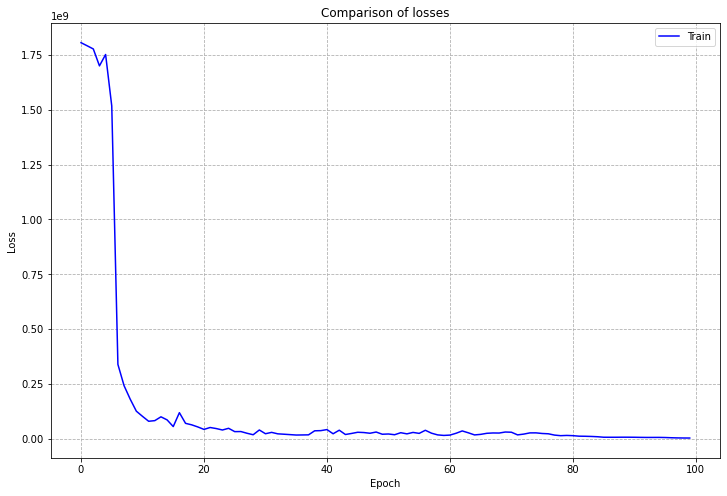

In [13]:
visualize(losses)

In [14]:
checkpoint = torch.load(os.path.join("weights", "99.pt"))
inferenced = MLP(config["Layers"])
inferenced.load_state_dict(checkpoint['model_state_dict'])
inferenced.eval()

MLP(
  (main): Sequential(
    (0): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (1): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (2): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (3): BlockAE(
      (main): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
      )
    )
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [17]:
inferenced(torch.tensor([0.15, 0.1, 0.1, 0.1]))

tensor([81828.3203,  4842.3574], grad_fn=<AddBackward0>)

In [16]:
df

,P11,P13,P21,P23,M1,M2
0,0.10,0.10,0.1,0.10,38170.011166,38170.011166
1,0.15,0.10,0.1,0.10,79158.334694,3788.763675
2,0.20,0.10,0.1,0.10,85342.003277,1545.490515
3,0.25,0.10,0.1,0.10,88496.264950,859.133914
4,0.30,0.10,0.1,0.10,90492.037140,551.071879
...,...,...,...,...,...,...
18491,0.15,0.75,0.1,0.85,8107.607711,4193.996264
18492,0.20,0.75,0.1,0.85,13534.129065,3751.287640
18493,0.10,0.80,0.1,0.85,4919.802853,4458.308901
18494,0.15,0.80,0.1,0.85,7072.949552,4268.834824
